In [1]:
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import jax.scipy.stats as stats
from jax import jacfwd, jacrev
from jax import vmap, grad, jit, random
from jax.tree_util import tree_map, tree_flatten, tree_unflatten, tree_leaves

from flax import nnx
import optax
import pcax

from tqdm.notebook import tqdm
from tqdm.notebook import trange

In [2]:
import os
os.chdir('../methods')
import lsci, supr, conf
os.chdir('../examples')

In [3]:
def split_data(data, lag, horizon):
    horizon = horizon-1
    y_t = data[(lag + horizon):][:,None]
    x_t = np.stack([data[(lag-i-1):(-(i+1+horizon))] for i in range(lag)], axis = 1)
    return x_t.copy(), y_t.copy()

In [4]:
def split_cal(yval_hat, yval):
    nval = yval.shape[0]
    nval2 = yval.shape[0]//2

    yval = yval.reshape(nval, -1)
    yval_hat = yval_hat.reshape(nval, -1)
    
    rval = yval - yval_hat
    rval1 = rval[:nval2]
    rval2 = rval[nval2:]
    yval1 = yval[:nval2]
    yval2 = yval[nval2:]
    yval_hat1 = yval_hat[:nval2]
    yval_hat2 = yval_hat[nval2:]
    return rval1, rval2, yval1, yval2, yval_hat1, yval_hat2

def project_cal(rval1, rval2, yval_hat2, nproj, pca_state):
    pca_state = pcax.fit(rval1, n_components=nproj)
    rval_proj = pcax.transform(pca_state, rval2)
    yval_hat_proj = pcax.transform(pca_state, yval_hat2)
    return rval_proj, yval_hat_proj

def project_test(ytest_hat, ytest = None, state = None):
    ntest = ytest_hat.shape[0]

    # reshape and compute residuals
    ytest_hat = ytest_hat.reshape(ntest, -1)
    ytest_hat_proj = pcax.transform(pca_state, ytest_hat)

    if ytest is not None:
        ytest = ytest.reshape(ntest, -1)
        rtest = ytest - ytest_hat
        rtest_proj = pcax.transform(pca_state, rtest)
        return rtest, rtest_proj, ytest_hat_proj

    return ytest_hat_proj

In [5]:
def risk_control(lower, upper, residual):
    return jnp.mean((residual > lower)*(residual < upper))

In [6]:
class ANO_layer(nnx.Module):
  def __init__(self, width, rngs: nnx.Rngs):
    self.linear = nnx.Linear(width, width, rngs=rngs)
    # self.bn = nnx.BatchNorm(dmid, rngs=rngs)
    # self.dropout = nnx.Dropout(0.2, rngs=rngs)
    self.linear_out = nnx.Linear(width, width, rngs=rngs)

  def __call__(self, x):
    # channel mix
    h = self.linear(x)

    # spatial mix
    g = jnp.mean(x, axis = (1, 2))[:,None,None,:]

    # sum
    x = h + g
    x = nnx.relu(x)

    return self.linear_out(x)

class encode_layer(nnx.Module):
  def __init__(self, in_dim, out_dim, rngs):
    self.linear = nnx.Linear(in_dim, out_dim, rngs=rngs)

  def __call__(self, x):
    return self.linear(x)

class DeepANO(nnx.Module):
  def __init__(self, in_dim, width, out_dim, rngs):
    self.encode_layer = encode_layer(in_dim, width, rngs)
    self.ano1 = ANO_layer(width, rngs)
    self.ano2 = ANO_layer(width, rngs)
    self.ano3 = ANO_layer(width, rngs)
    self.decode_layer = encode_layer(width, out_dim, rngs)

  def __call__(self, x):
    x = self.encode_layer(x)
    x = self.ano1(x)
    x = self.ano2(x)
    x = self.ano3(x)
    x = self.decode_layer(x)
    return x

@nnx.jit  # Automatic state management
def train_step(model, optimizer, x, y):
  def loss_fn(model):
    y_pred = model(x)
    y_diff = jnp.diff(y_pred, axis = 0)
    return jnp.mean((y_pred - y) ** 2) + jnp.mean(y_diff**2)

  loss, grads = nnx.value_and_grad(loss_fn)(model)
  optimizer.update(grads)  # In place updates.

  return loss

In [7]:
key1 = random.PRNGKey(0)
key2 = random.PRNGKey(0)
key3 = random.PRNGKey(0)

t = jnp.linspace(0, 1, 100)
s = jnp.linspace(-2*math.pi, 2*math.pi, 501)

amp = jnp.sin(s)
sd = jnp.sin(s)

f = jnp.sin(2 * math.pi * t)
f = amp[:,None] * f[None,:]

xtrain = f + 0.25 * (1.15 + sd)[:,None] * random.normal(key1, f.shape)
xtrain, ytrain = split_data(xtrain, 1, 1)
xtrain = xtrain[:,:,:,None]
ytrain = ytrain[:,:,:,None]

xval = f + 0.25 * (1.15 + sd)[:,None] * random.normal(key2, f.shape)
xval, yval = split_data(xval, 1, 1)
xval = xval[:,:,:,None]
yval = yval[:,:,:,None]

xtest = f + 0.25 * (1.15 + sd)[:,None] * random.normal(key3, f.shape)
xtest, ytest = split_data(xtest, 1, 1)
xtest = xtest[:,:,:,None]
ytest = ytest[:,:,:,None]

In [8]:
model = DeepANO(1, 50, 1, nnx.Rngs(0))
optimizer = nnx.Optimizer(model, optax.adam(1e-3)) 

epochs = 50
nbat = 50
for _ in trange(epochs):
    for i in trange(len(f)//nbat, leave = False):
        xi = xtrain[i*nbat:(i+1)*nbat]
        yi = ytrain[i*nbat:(i+1)*nbat]

        loss = train_step(model, optimizer, xi, yi)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [9]:
yval_hat = model(xval)
ytest_hat = model(xtest)

In [10]:
nval = yval.shape[0]
nval2 = yval.shape[0]//2
ntest = ytest_hat.shape[0]
# nlat, nlon = 32, 64
nproj = 90

# split calibration dataset
yval = yval.reshape(nval, -1)
yval_hat = yval_hat.reshape(nval, -1)
rval = yval - yval_hat
rval1, rval2, yval1, yval2, yval_hat1, yval_hat2 = split_cal(yval_hat, yval)

# process test dataset
ytest = ytest.reshape(ntest, -1)
ytest_hat = ytest_hat.reshape(ntest, -1)
# ytest_quant = ytest_quant.reshape(ntest, -1)
rtest = ytest - ytest_hat

# project calibration and test
pca_state = pcax.fit(rval1, n_components=nproj)
rval_proj2, yval_hat_proj2 = project_cal(rval1, rval2, yval_hat2, nproj, pca_state)
rtest, rtest_proj, ytest_hat_proj = project_test(ytest_hat, ytest, pca_state)

In [11]:
yval_hat2.shape, xtest.shape

((250, 100), (500, 1, 100, 1))

In [12]:
gamma1 = 0.2
# gamma2 = 0.5
alpha = 0.1
alpha1 = 1 - jnp.ceil((1-alpha) * (gamma1*nval2 + 1))/(gamma1*nval2)
# alpha2 = 1 - jnp.ceil((1-alpha) * (gamma2*nval2 + 1))/(gamma2*nval2)

lweight1 = lsci.local_weights(pcax.transform(pca_state, xval[0:250].squeeze()), 
                              pcax.transform(pca_state, xtest.squeeze()),
                              gamma1)
# lweight2 = lsci.local_weights(pcax.transform(pca_state, yval_hat2), 
#                         pcax.transform(pca_state, ytest_hat), 
#                         gamma2)

In [48]:
alpha = 0.1

lsc1_rc = []
lsc1_width = []

conf_rc = []
conf_width = []

conf_lower, conf_upper = conf.conf_band(rval2, pca_state, alpha)

# for i in trange(ytest.shape[0]):
for i in trange(0, 400):
    
    # LSCI (sparse)
    lsc1_lower, lsc1_upper = lsci.lsci_band(rval2, lweight1[i], pca_state, alpha1, 2000)
    lsc1_rc.append(risk_control(lsc1_lower, lsc1_upper, rtest[i]))
    lsc1_width.append(jnp.median(lsc1_upper - lsc1_lower))
    
    # CONF 
    conf_rc.append(risk_control(conf_lower, conf_upper, rtest[i]))
    conf_width.append(jnp.mean(conf_upper - conf_lower))
    
conf_rc = np.array(conf_rc)
lsc1_rc = np.array(lsc1_rc)
# lsc2_rc = np.array(lsc2_rc)

conf_width = np.array(conf_width)
lsc1_width = np.array(lsc1_width)
# lsc2_width = np.array(lsc2_width)

  0%|          | 0/400 [00:00<?, ?it/s]

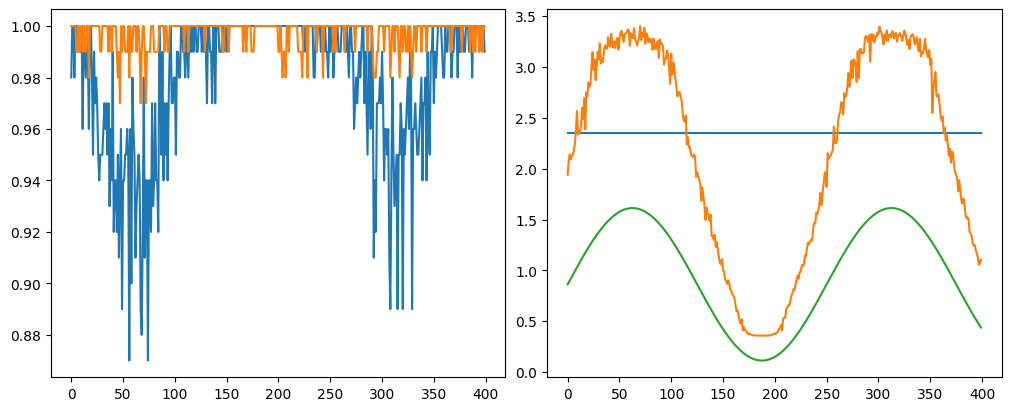

In [55]:
fig, ax = plt.subplots(1, 2, constrained_layout = True, figsize = (10, 4))
ax[0].plot(conf_rc)
ax[0].plot(lsc1_rc)
ax[1].plot(conf_width)
ax[1].plot(lsc1_width)
ax[1].plot(3 * (0.25 * (1.15 + sd))[0:400])
plt.show()

In [65]:
alpha = 0.1

lsc1_rc = []
lsc1_width = []

conf_rc = []
conf_width = []

lsci_lower = []
lsci_upper = []

conf_lower, conf_upper = conf.conf_band(rval2, pca_state, alpha)

# for i in trange(ytest.shape[0]):
sample_no = [0, 50, 200]
for i in sample_no:
    # LSCI (sparse)
    lsc1_lower, lsc1_upper = lsci.lsci_band(rval2, lweight1[i], pca_state, alpha1, 2000)
    
    lsci_lower.append(lsc1_lower)
    lsci_upper.append(lsc1_upper)

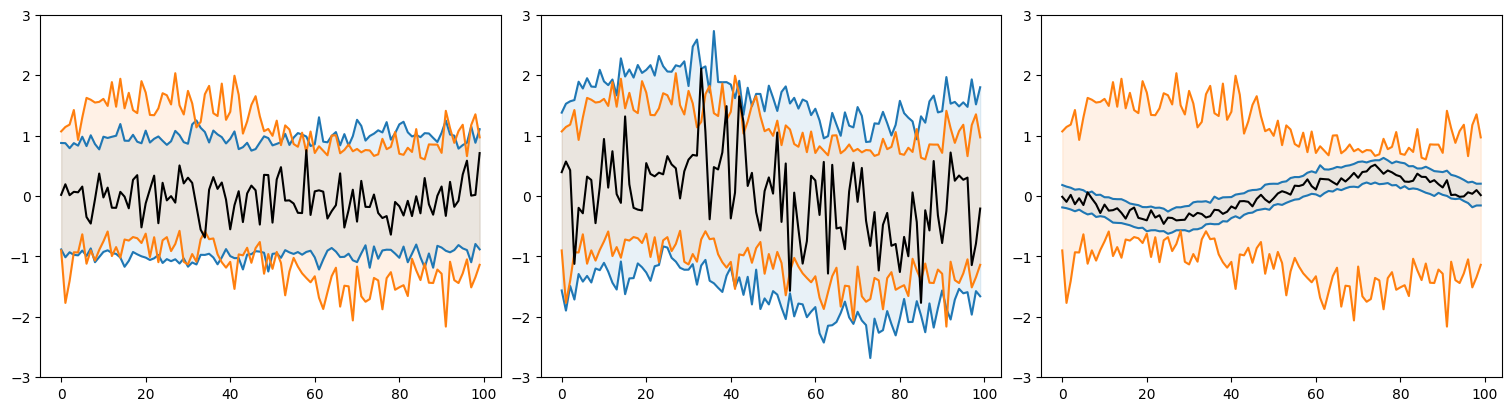

In [73]:
fig, ax = plt.subplots(1, 3, constrained_layout = True, figsize = (15, 4))

for i in range(3):
    ax[i].plot(lsci_lower[i], c = 'C0')
    ax[i].plot(lsci_upper[i], c = 'C0')
    ax[i].fill_between(jnp.arange(100), lsci_lower[i], lsci_upper[i], alpha = 0.1, color = 'C0')
    ax[i].plot(conf_lower, c = 'C1')
    ax[i].plot(conf_upper, c = 'C1')
    ax[i].fill_between(jnp.arange(100), conf_lower, conf_upper, alpha = 0.1, color = 'C1')
    ax[i].plot(rtest[sample_no[i]].squeeze(), c = 'black')
    
    ax[i].set_ylim(-3, 3)
plt.show()